In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [4]:

# DataFrame에서 각 열의 결측치 비율 계산
missing_percentage = (train.isnull().sum() / len(train)) * 100

# 결과 출력
print(missing_percentage)


ARI_CO                 0.000000
ARI_PO                 0.000000
SHIP_TYPE_CATEGORY     0.000000
DIST                   0.000000
ATA                    0.000000
ID                     0.000000
BREADTH                0.000272
BUILT                  0.000000
DEADWEIGHT             0.000000
DEPTH                  0.000272
DRAUGHT                0.000272
GT                     0.000000
LENGTH                 0.000272
SHIPMANAGER            0.000000
FLAG                   0.000000
U_WIND                41.771604
V_WIND                41.771604
AIR_TEMPERATURE       42.010826
BN                    41.771604
ATA_LT                 0.000000
DUBAI                  0.000000
BRENT                  0.000000
WTI                    0.000000
BDI_ADJ                0.000000
PORT_SIZE              0.000000
CI_HOUR                0.000000
dtype: float64


In [5]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]


In [6]:
import pandas as pd

# train DataFrame의 열 이름 확인
column_names = train.columns

# 열 이름 출력
print(column_names)


Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')


In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 데이터 불러오기
# 여기에서 train DataFrame은 ARI_CO, ARI_PO, year, month, day, hour, minute, AIR_TEMPERATURE 열을 포함해야 합니다.

# 결측치가 0인 행을 추출
missing_temperature_indices = train[train['AIR_TEMPERATURE'] == 0].index

# 훈련 데이터 준비
X_train = train[train['AIR_TEMPERATURE'] != 0][['ARI_CO', 'ARI_PO', 'year', 'month', 'day', 'hour', 'minute']]
y_train = train[train['AIR_TEMPERATURE'] != 0]['AIR_TEMPERATURE']

# 비선형 회귀 모델 선택 (랜덤 포레스트 회귀 사용)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 훈련
regressor.fit(X_train, y_train)

# 결측치를 예측하여 채워넣음
X_missing = train.loc[missing_temperature_indices, ['ARI_CO', 'ARI_PO', 'year', 'month', 'day', 'hour', 'minute']]
predicted_temperatures = regressor.predict(X_missing)

# 예측된 값을 결측치에 채워넣음
train.loc[missing_temperature_indices, 'AIR_TEMPERATURE'] = predicted_temperatures


In [86]:
train.to_csv('preprocessing2.csv', index=False) 

In [63]:
train = pd.read_csv('preprocessing2.csv')

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


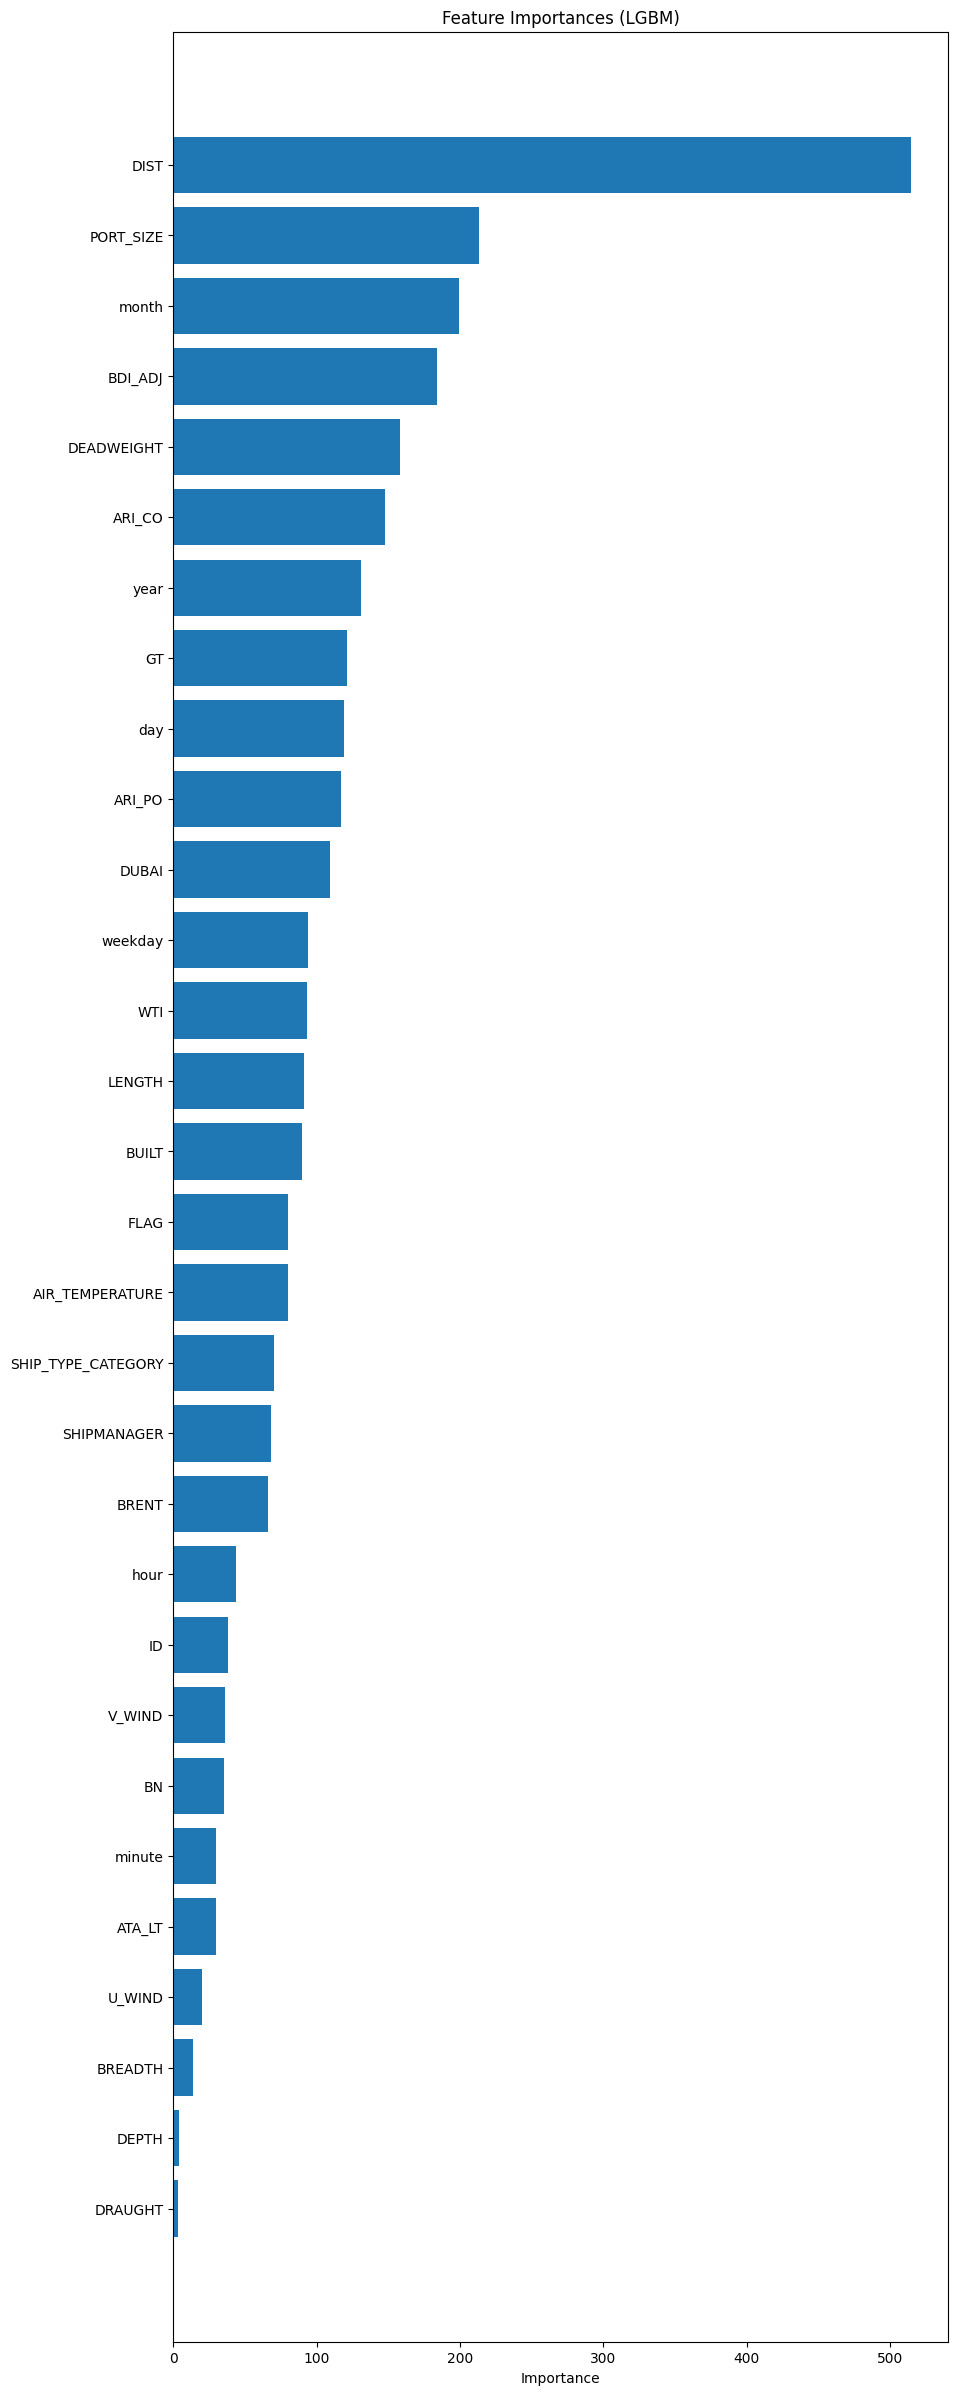

In [64]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [67]:
threshold = 40 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [68]:
print(low_importance_features)

Index(['ID', 'BREADTH', 'DEPTH', 'DRAUGHT', 'U_WIND', 'V_WIND', 'BN', 'ATA_LT',
       'minute'],
      dtype='object')


In [69]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor()  # XGBoost 모델 생성

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    xgb_model.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb_model.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = xgb_model.predict(X_test_reduced)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)
    
    ensemble_predictions.append(xgb_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]

Validation : MAE scores for each fold: [45.06655690735753, 46.066123099138494, 46.166945125715415, 46.59631152799349, 44.71838223731452]
Validation : MAE: 45.722863779503896


In [36]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('AIChallenge3.csv', index=False)